# Homework Assignment 10

**Question 1:** Use PySpark and the [Wine Reviews dataset](https://www.kaggle.com/zynicide/wine-reviews) to:
- Explore  the datasets using Spark DataFrame by creating **3 different data visualizations, including map visualization** (30pt)
- Create a regression model that can predict the Wine Review's points value and evaluate the model(20pt)

In [1]:
!pip install pyspark

     -------------------------------------- 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 200.5/200.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488537 sha256=cb0eebe40229aa6443ca4f93127cf55b4b40485a6f7686c1443e1c20eec3c114
  Stored in directory: c:\users\kazom\appdata\local\pip\cache\wheels\da\78\6d\54350e0243f65f77dccf6ebe2ed5559faf6900559e904fb957
Successfully built pyspark


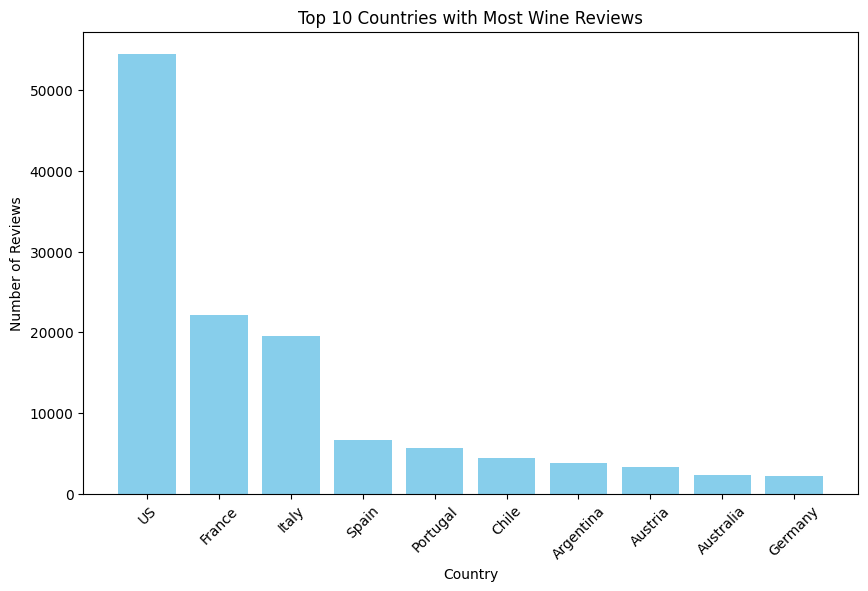

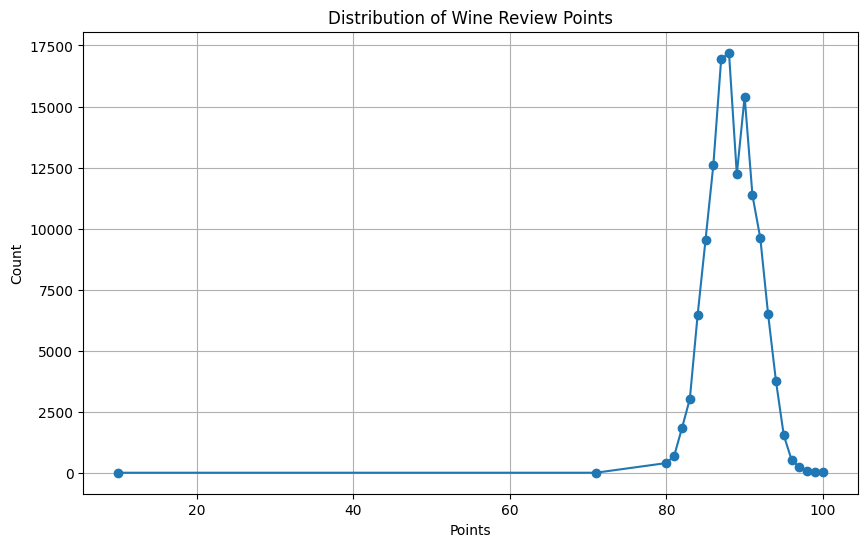

Root Mean Squared Error (RMSE): 2.7267844467236615


In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import plotly.express as px

# Create a Spark session
spark_session = SparkSession.builder \
    .appName("Wine_Reviews_Analysis") \
    .getOrCreate()

# Load the Wine Reviews dataset into a DataFrame
wine_data = spark_session.read.format("csv") \
    .option("header", "true") \
    .load("winemag-data-130k-v2.csv")

# Convert "points" and "price" columns to numeric type
wine_data = wine_data.withColumn("points", wine_data["points"].cast("double"))
wine_data = wine_data.withColumn("price", wine_data["price"].cast("double"))

# Data Exploration and Visualization

# Calculate average points by country
avg_points_country_df = wine_data.groupBy("country").avg("points").orderBy("avg(points)", ascending=False).toPandas()

# Visualize average points by country using a choropleth map
fig_avg_points_country = px.choropleth(avg_points_country_df, locations="country", color="avg(points)", 
                                       hover_name="country", hover_data=["avg(points)"], locationmode="country names")
fig_avg_points_country.update_layout(title_text="Average Wine Points by Country", title_x=0.5)
fig_avg_points_country.show()

# Count number of reviews by country
reviews_by_country_df = wine_data.groupBy("country").count().orderBy("count", ascending=False).limit(10).toPandas()

# Visualize top 10 countries with most wine reviews using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(reviews_by_country_df["country"], reviews_by_country_df["count"], color='skyblue')
plt.xlabel("Country")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Countries with Most Wine Reviews")
plt.xticks(rotation=45)
plt.show()

# Calculate distribution of points
points_distribution_df = wine_data.groupBy("points").count().orderBy("points").toPandas()

# Visualize distribution of points using a line chart
plt.figure(figsize=(10, 6))
plt.plot(points_distribution_df["points"], points_distribution_df["count"], marker='o', linestyle='-')
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Distribution of Wine Review Points")
plt.grid(True)
plt.show()

# Regression Model

# Select relevant columns for regression model
selected_wine_data = wine_data.select("points", "price", "country", "variety", "region_1")

# Drop rows with missing values
selected_wine_data = selected_wine_data.dropna()

# Convert categorical columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(selected_wine_data) for column in ["country", "variety", "region_1"]]
indexers_pipeline = Pipeline(stages=indexers)
indexed_data = indexers_pipeline.fit(selected_wine_data).transform(selected_wine_data)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["price", "country_index", "variety_index", "region_1_index"], outputCol="features")
assembled_data = assembler.transform(indexed_data)

# Split data into training and testing sets
(training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# Create a Linear Regression model
regression_model = LinearRegression(labelCol="points", featuresCol="features")

# Train the model
trained_model = regression_model.fit(training_data)

# Make predictions on testing data
predictions = trained_model.transform(testing_data)

# Evaluate the model using RMSE metric
evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Stop the Spark session
spark_session.stop()


**Question 2:** Use PySpark and the [Used Car Listings dataset](https://www.kaggle.com/jpayne/852k-used-car-listings) to:
- Explore  the datasets using Spamrk DataFrame by creating **3 different data visualizations, including  map visualization** (30pt)
- Create a regression model that can predict a car's listing price and evaluate the model (20pt)



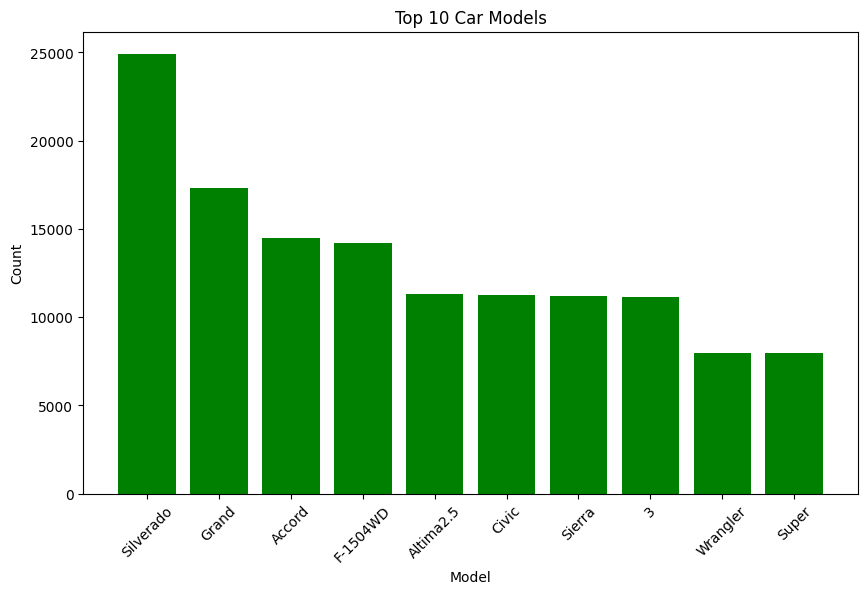

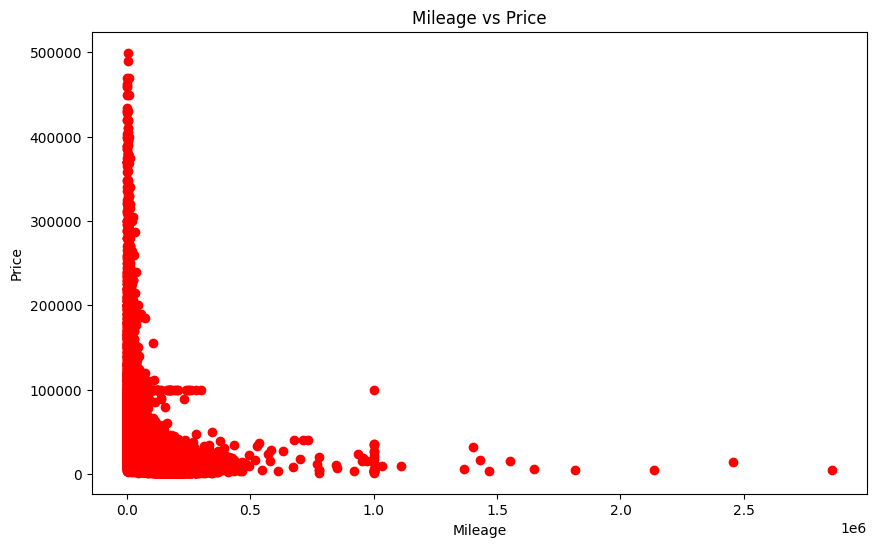

Root Mean Squared Error (RMSE): 12318.87052547449


In [11]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import plotly.express as px

# Create a Spark session
spark_session = SparkSession.builder \
    .appName("UsedCarListings") \
    .getOrCreate()

# Load the dataset
car_data = spark_session.read.csv("true_car_listings.csv", header=True, inferSchema=True)

# Data Exploration and Visualization

# Visualization 1: Choropleth of the Average Car Price by State
state_avg_price = car_data.groupBy("state").avg("price").orderBy("avg(price)", ascending=False).toPandas()
state_avg_price['state'] = state_avg_price['state'].str.strip().str.upper()
fig_state_avg_price = px.choropleth(state_avg_price, locations="state",
                                    color="avg(price)",
                                    hover_name="state",
                                    hover_data=["avg(price)"],
                                    locationmode="USA-states",
                                    scope="usa")
fig_state_avg_price.update_layout(title_text="Average Car Price by State", title_x=0.5)
fig_state_avg_price.show()

# Visualization 2: Bar chart of Car Brands
brand_counts = car_data.groupBy("Model").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
plt.bar(brand_counts["Model"], brand_counts["count"], color='green')
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Top 10 Car Models")
plt.xticks(rotation=45)
plt.show()

# Visualization 3: Scatter plot of Mileage vs Price
mileage_price_data = car_data.select("Mileage", "Price").toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(mileage_price_data["Mileage"], mileage_price_data["Price"], color='red')
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Mileage vs Price")
plt.show()

# Regression Model

# Prepare data for regression
assembler = VectorAssembler(inputCols=["Year", "Mileage"], outputCol="features")
car_data = assembler.transform(car_data)
train_data, test_data = car_data.randomSplit([0.8, 0.2])

# Create a Linear Regression model
linear_regression = LinearRegression(labelCol="Price", featuresCol="features")
regression_model = linear_regression.fit(train_data)

# Evaluate the model
predictions = regression_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Close the Spark session
spark_session.stop()


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("UsedCarListings").getOrCreate()

# Load the dataset
data = spark.read.csv("true_car_listings.csv", header=True, inferSchema=True)

# Feature Engineering
# Logarithmic scaling of Mileage and Price
data = data.withColumn("LogMileage", F.log(data["Mileage"] + 1))
data = data.withColumn("LogPrice", F.log(data["Price"] + 1))

# Feature Selection
selected_features = ["Year", "LogMileage", "LogPrice"]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
data = assembler.transform(data)

# Model Selection
# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="LogPrice", maxDepth=10, numTrees=100)

# Pipeline for Standardization and Model Training
pipeline = Pipeline(stages=[StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True), rf])
train_data, test_data = data.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="LogPrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Close the Spark session
spark.stop()


Root Mean Squared Error (RMSE): 0.09075272258661066
